# Homework 5
<span style="font-size:1.25em"> Emre Kara  </span>  
<span style="font-size:1em"> 12.12.2020 </span>

# Question 1

## Data Load and Preparation

In [1]:
#Libraries
require(dplyr, quietly = TRUE)
require(data.table, quietly = TRUE)
require(glue, quietly = TRUE)
require(ggplot2, quietly = TRUE)
require(scatterplot3d, quietly = TRUE)
require(gridExtra, quietly = TRUE)
require(tidyr, quietly = TRUE)

Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last

Warning message:
"package 'glue' was built under R version 3.6.3"
Attaching package: 'glue'

The following object is masked from 'package:dplyr':

    collapse

Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'gridExtra' was built under R version 3.6.3"
Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine

Warning message:
"package 'tidyr' was built under R version 3.6.3"

In [15]:
#Dataload
axes <- c("X","Y","Z")
df <- list(); dftest <- list()

for (i in axes){
    df[[length(df) + 1]] <- fread(glue("Data/Train/uWaveGestureLibrary_{i}_TRAIN"))
    dftest[[length(dftest) + 1]] <- fread(glue("Data/Test/uWaveGestureLibrary_{i}_TEST"))
    
}

In [16]:
for (i in 1:3){
    ax = axes[i]

    #Train Data Preparation
    
    df[[i]][,"Observation"] = 1:dim(df[[i]])[1]
    setcolorder(df[[i]], c(length(df[[i]]),1,2:(length(df[[i]])-1)))
    #New Colnames
    newcolnames <- c("Observation","Class",1:(length(df[[1]])-2))
    newcolnames <- c("Observation","Class",paste(glue("{ax}"),"_t",newcolnames[3:length(newcolnames)],sep="")) 
    colnames(df[[i]]) = newcolnames
    
    #Test Data Preparation
    
    dftest[[i]][,"Observation"] = 1:dim(dftest[[i]])[1]
    setcolorder(dftest[[i]], c(length(dftest[[i]]),1,2:(length(dftest[[i]])-1)))
    #New Colnames
    newcolnames <- c("Observation","Class",1:(length(dftest[[1]])-2))
    newcolnames <- c("Observation","Class",paste(glue("{ax}"),"_t",newcolnames[3:length(newcolnames)],sep=""))
    colnames(dftest[[i]]) = newcolnames
}


In [17]:
# Merging Tables

dfmerged <- merge(df[[1]], df[[2]], by = c("Observation", "Class"), all=TRUE)
dfmerged <- merge(dfmerged, df[[3]], by = c("Observation", "Class"), all=TRUE)

dftestmerged <- merge(dftest[[1]], dftest[[2]], by = c("Observation", "Class"), all=TRUE)
dftestmerged <- merge(dftestmerged, dftest[[3]], by = c("Observation", "Class"), all=TRUE)

In [18]:
# Missing Data Check
which(is.na(dfmerged),TRUE);which(is.na(dftestmerged),TRUE)

row,col


row,col


Source data consists of time series observations in three axes: X, Y and Z. Each row of the final data table corresponds to a serie and distances betweens these series (observations) will be calculated.

In [19]:
head(dfmerged)

Observation,Class,X_t1,X_t2,X_t3,X_t4,X_t5,X_t6,X_t7,X_t8,...,Z_t306,Z_t307,Z_t308,Z_t309,Z_t310,Z_t311,Z_t312,Z_t313,Z_t314,Z_t315
1,6,-0.304243210,-0.304243210,-0.304243210,-0.304243210,-0.304243210,-0.304243210,-0.304243210,-0.304243210,...,0.5232168,0.5139944,0.50348075,0.49296714,0.47452222,0.4560773,0.4376324,0.4191875,0.4007426,0.3822976
2,5,1.627311100,1.627311100,1.627311100,1.627311100,1.627311100,1.627311100,1.627311100,1.627311100,...,-0.4270104,-0.4270104,-0.42701043,-0.42717222,-0.42877307,-0.4407199,-0.4526667,-0.4646135,-0.4765603,-0.4885071
3,5,0.661276530,0.661276530,0.661276530,0.661276530,0.661276530,0.661276530,0.661276530,0.661276530,...,-0.8627172,-0.8627172,-0.86271720,-0.86271720,-0.86271720,-0.8627172,-0.8627172,-0.8627172,-0.8627172,-0.8627172
4,3,0.005184784,0.005184784,0.005184784,0.005184784,0.005184784,0.005184784,0.005184784,0.005184784,...,-0.1873845,-0.1235489,-0.05587047,0.01180812,0.07948656,0.1570561,0.2537396,0.4455027,0.6485381,0.8515735
5,4,1.286197800,1.286197800,1.286197800,1.286197800,1.286197800,1.286197800,1.286197800,1.286197800,...,1.8674725,1.8343190,1.75599960,1.63858220,1.52116390,1.4532661,1.5152189,1.6326367,1.7500543,1.8674725
6,8,-0.479252460,-0.479252460,-0.479252460,-0.479252460,-0.479252460,-0.479252460,-0.479252460,-0.479252460,...,0.6979770,0.6654623,0.63294758,0.60043289,0.55859021,0.5167475,0.4679755,0.4192035,0.3704314,0.3216594


## Task a: Train

Before applying k-NN algorithm, distance measures of time series observations are calculated. Two distance measures are adapted:  
- Euclidian:  $ d_{ij} = \sum_{k = 1}^p{(x_{ik} - x_{jk})^2}  $
- Manhattan:     $ d_{ij} = \sum_{k = 1}^p {\lvert x_{ik} - x_{jk} \rvert }  $  

Where i and j are observations and p is the number of variables.

In [105]:
kfoldsplit <- function(data,k,order){
    order <- (order-1) %% k + 1
    n <- dim(data)[1]
    size <- ceiling(n/k)
    idx <- ((order-1)*size + 1):(min(order*size,n))
    
    train <- data[-idx]
    valid <- data[idx]
    res <- list()
    res[[1]] <- train
    res[[2]] <- valid
    return(res)
}

In [233]:
getmode <- function(v) {
    v <- as.vector(v)
   tbl <- table(v)
   return(names(which.max(tbl)))
}

In [234]:
grid = 1:20

In [237]:
knnfit <- function(df, foldnum = 10, grid = 1:2)
{
    start <- Sys.time()
    AccEuc <- NULL; AccMan <- NULL; allpredseuc <- NULL; allpredsman <- NULL
    
    for(K in grid){
        cat("K= ",K) 
        cvAccEuc <- NULL; cvAccMan <- NULL; cvpredseuc <- NULL; cvpredsman <- NULL
        
        for (fold in 1:foldnum){
            cat("fold %d",fold)
            
            split = kfoldsplit(df,foldnum,fold)
            train <- split[[1]][,-c(1,2)]
            valid <- split[[2]][,-c(1,2)]
            trainclass <- split[[1]][,2]
            validclass <- split[[2]][,2]
            combined=rbind(valid,train)
            
            eucdistcombined = as.matrix(dist(combined, method = "euclidian")) # Euclidian Distance
            mandistcombined = as.matrix(dist(combined, method = "manhattan")) # Manhattan Distance
            
            lnvalid = dim(valid)[1]; lntrain = dim(train)[1]; lnall = lnvalid + lntrain
            
            eucdistcombined = eucdistcombined[1:lnvalid,(lnvalid+1):lnall]
            mandistcombined = mandistcombined[1:lnvalid,(lnvalid+1):lnall]
            
            neighbors_euc = t(apply(eucdistcombined, 1, order))
            neighbors_man = t(apply(mandistcombined, 1, order))
            
            idxeuc = t(apply(neighbors_euc, 1, function(x) x[1:K] ) )
            idxman = t(apply(neighbors_man, 1, function(x) x[1:K] ) )
            
            predseuc = apply(idxeuc, 1, function(x) as.numeric(getmode( trainclass[as.vector(x),1] )) )
            predsman = apply(idxman, 1, function(x) as.numeric(getmode( trainclass[as.vector(x),1] )) )
                         
            cvAccEuc <- c( cvAccEuc, sum(validclass == predseuc)/dim(validclass)[1] )
            cvAccMan <- c( cvAccMan, sum(validclass == predsman)/dim(validclass)[1] )
        }                 
        AccEuc <- rbind(AccEuc, t(c(K,cvAccEuc))); AccMan <- rbind(AccMan, t(c(K,cvAccMan)))
    }
    str(Sys.time() - start)
    res = list();
    res[[ length(res) + 1]] = AccEuc; res[[ length(res) + 1]] = AccMan
    return(res)
}
                                           

In [ ]:
fit <- knnfit(dfmerged, 10, grid)

In [239]:
meanAccEuc <- cbind(fit[[1]][,1],apply(fit[[1]][,-1],1,mean))
meanAccMan <- cbind(fit[[2]][,1],apply(fit[[2]][,-1],1,mean))

Accuracy is calculated as: $$ \frac{True Positive + True Negative}{ Total Observations}$$and error rate is calculated as: $$ \frac{False Positive + False Negative}{Total Observations} = 1 - Accuracy$$   
Hence, to minimize error rate, we can maximize accuracy.

### Euclidian Distance 

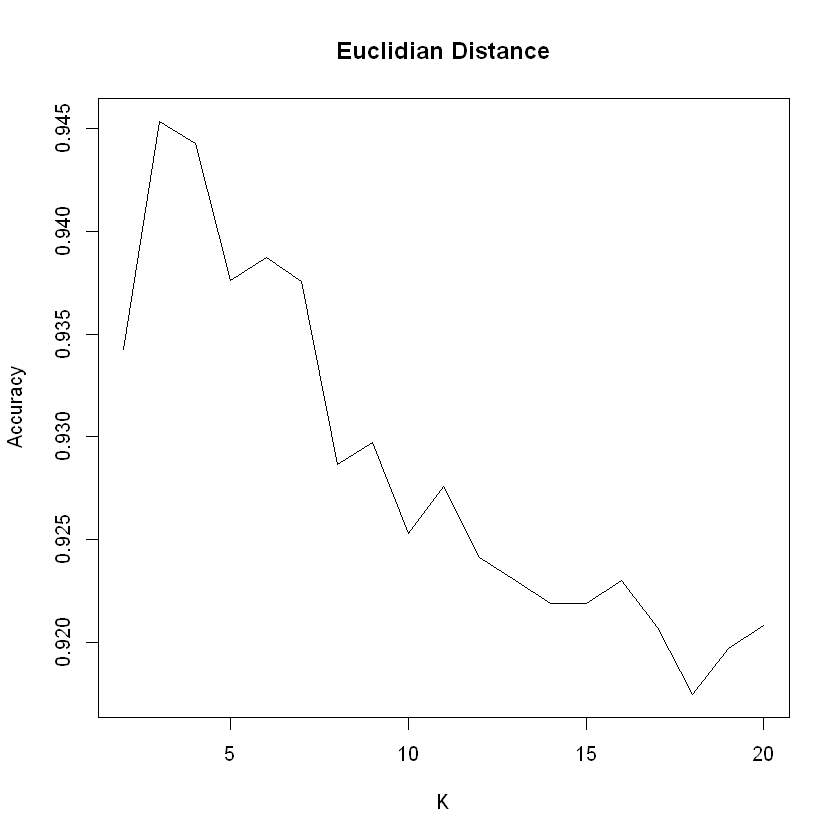

In [246]:
plot(meanAccEuc[-1,1],meanAccEuc[-1,2],type = 'l', ylab="Accuracy",xlab="K", main = "Euclidian Distance")

In [249]:
meanAccEuc[which.max(meanAccEuc[,2]),1]

[1] 3

In [253]:
meanAccEuc[which.max(meanAccEuc[,2]),2]

[1] 0.9453488

Optimum K value is **3** for **Euclidian Distance**. Accuracy value for K=3 is **94.5349%**.

### Manhattan Distance

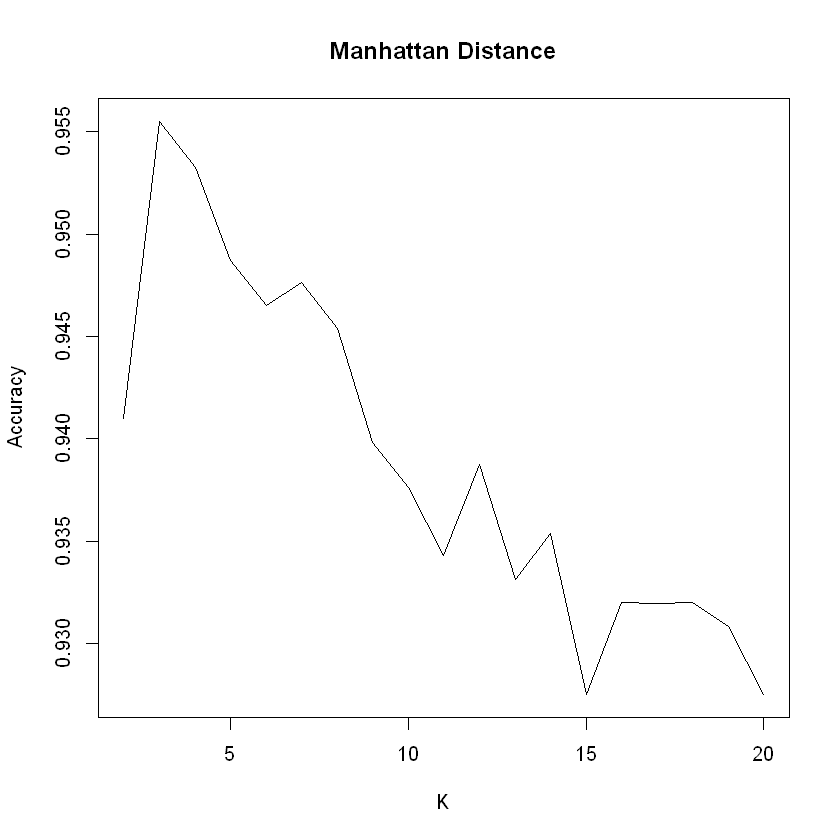

In [250]:
plot(meanAccMan[-1,1],meanAccMan[-1,2],type = 'l', ylab="Accuracy",xlab="K", main = "Manhattan Distance")

In [251]:
meanAccMan[which.max(meanAccMan[,2]),1]

[1] 3

In [254]:
meanAccMan[which.max(meanAccMan[,2]),2]

[1] 0.9555039

Optimum K value is same for **Manhattan Distance** as well:  **3**. The accuracy value is higher from the previous approach: **95.5504%** 

## Task b: Test

In [263]:
knntest <- function(traindf, testdf, K)
{
    start <- Sys.time()
    AccEuc <- NULL; AccMan <- NULL; allpredseuc <- NULL; allpredsman <- NULL

    train <- traindf[,-c(1,2)]
    test <- testdf[,-c(1,2)]
    trainclass <- traindf[,2]
    testclass <- testdf[,2]
    combined=rbind(test,train)
    
    eucdistcombined = as.matrix(dist(combined, method = "euclidian")) # Euclidian Distance
    mandistcombined = as.matrix(dist(combined, method = "manhattan")) # Manhattan Distance
    
    lntest = dim(test)[1]; lntrain = dim(train)[1]; lnall = lntest + lntrain
    
    eucdistcombined = eucdistcombined[1:lntest,(lntest+1):lnall]
    mandistcombined = mandistcombined[1:lntest,(lntest+1):lnall]
    
    neighbors_euc = t(apply(eucdistcombined, 1, order))
    neighbors_man = t(apply(mandistcombined, 1, order))
    
    idxeuc = t(apply(neighbors_euc, 1, function(x) x[1:K] ) )
    idxman = t(apply(neighbors_man, 1, function(x) x[1:K] ) )
    
    predseuc = apply(idxeuc, 1, function(x) as.numeric(getmode( trainclass[as.vector(x),1] )) )
    predsman = apply(idxman, 1, function(x) as.numeric(getmode( trainclass[as.vector(x),1] )) )
                 
    AccEuc <- sum(testclass == predseuc)/dim(testclass)[1]
    AccMan <- sum(testclass == predsman)/dim(testclass)[1]
    
    res = list();
    res[[ length(res) + 1]] = predseuc; res[[ length(res) + 1]] = AccEuc
    res[[ length(res) + 1]] = predsman; res[[ length(res) + 1]] = AccMan
    str(Sys.time() - start)
    return(res)
}
                                           

In [264]:
preds <- knntest(dfmerged, dftestmerged, K = 3)

 'difftime' num 2.20502690076828
 - attr(*, "units")= chr "mins"


The algorithm took **2.21 minutes** to run.

In [267]:
lapply(preds,head)

[[1]]
1 2 3 4 5 6 
5 1 4 4 5 4 

[[2]]
[1] 0.9438861

[[3]]
1 2 3 4 5 6 
5 1 4 4 5 4 

[[4]]
[1] 0.9500279

### Euclidian Distance 

In [275]:
cat("EUCLIDIAN DISTANCE CONFUSION MATRIX")
table( cbind(Actuals = dftestmerged[,2] ,Predictions = preds[[1]]  ) )
cat("Accuracy is: ",preds[[2]]*100,"%" )

EUCLIDIAN DISTANCE CONFUSION MATRIX

             Predictions
Actuals.Class   1   2   3   4   5   6   7   8
            1 431   0   0   2   0   4   0   0
            2   1 449   0   0   0   0   2   0
            3   2   0 413   0  15  20   4   0
            4   7   0   0 370  60   6   0   7
            5   3   0   6   1 422   1   0   0
            6   6   0   7  15  28 392   1   0
            7   0   0   1   0   0   0 446   0
            8   0   0   0   1   1   0   0 458

Accuracy is:  94.38861 %

### Manhattan Distance 

In [276]:
cat("MANHATTAN DISTANCE CONFUSION MATRIX")
table( cbind(Actuals = dftestmerged[,2] ,Predictions = preds[[3]]  ) )
cat("Accuracy is: ",preds[[4]]*100,"%" )

MANHATTAN DISTANCE CONFUSION MATRIX

             Predictions
Actuals.Class   1   2   3   4   5   6   7   8
            1 432   0   0   2   0   3   0   0
            2   1 451   0   0   0   0   0   0
            3   3   0 420   0  11  16   4   0
            4   3   0   0 385  48   7   0   7
            5   3   0   5   2 422   1   0   0
            6  10   0   4  16  25 394   0   0
            7   0   0   5   0   0   0 442   0
            8   0   0   0   2   1   0   0 457

Accuracy is:  95.00279 %

## Task c: Weighted Distances

When we calculate **Euclidian** distance matrix using all axes, in fact, we calculate **quadratic mean** of Euclidian distances based on all axes seperately. Quadratic mean is always greater than arithmetic mean which means this approach calculates distance closer to higher values. As for Manhattan distance, calculating overall distance or arihmetic mean of axis based distances yields the same result.

If distances based on all axes are equally important, weighted approach with equal weights would be more sensible to calculate distances. Better accuracy results in both crass-validation and test sets also solidify this assumption. Hence, as an alternative approach, **arithmetic mean of axis based Euclidian distances** can be used.

One other approach could be deciding importance of axis based distances looking at absolute correlation values. Sum of correlation values between instance classes and axis observations can be decided as weight of each axis and then the **correlation weighted average of axis based Euclidian/Manhattan distances** can be used as total distance.




In [289]:
# Calculting correlation weights (-1 to remove observation ID's)
wx = sum(cor(dfmerged[,-1])[1,2:316])
wy = sum(cor(dfmerged[,-1])[1,317:631])
wz = sum(cor(dfmerged[,-1])[1,632:946])
wtot = wx + wy + wz

In [290]:
wx = wx/wtot; wx
wy = wy/wtot; wy
wz = wz/wtot; wz

[1] 0.6028562

[1] 0.2362128

[1] 0.160931

X axis has the highest effect.

In [305]:
weightedknn <- function(dflist, dftestlist, wx, wy, wz, K)
{
    start <- Sys.time()
    AccEuc <- NULL; AccMan <- NULL; allpredseuc <- NULL; allpredsman <- NULL

    trainx <- dflist[[1]][,-c(1,2)]
    trainy <- dflist[[2]][,-c(1,2)]
    trainz <- dflist[[3]][,-c(1,2)]
    trainclass <- dflist[[1]][,2]
    
    testx <- dftestlist[[1]][,-c(1,2)]
    testy <- dftestlist[[2]][,-c(1,2)]
    testz <- dftestlist[[3]][,-c(1,2)]
    testclass <- dftestlist[[1]][,2]

    combinedx=rbind(testx,trainx)
    combinedy=rbind(testy,trainy)
    combinedz=rbind(testz,trainz)
    
    eucdistcombinedx = as.matrix(dist(combinedx, method = "euclidian"))
    mandistcombinedx = as.matrix(dist(combinedx, method = "manhattan"))
    eucdistcombinedy = as.matrix(dist(combinedy, method = "euclidian"))
    mandistcombinedy = as.matrix(dist(combinedy, method = "manhattan"))
    eucdistcombinedz = as.matrix(dist(combinedz, method = "euclidian"))
    mandistcombinedz = as.matrix(dist(combinedz, method = "manhattan"))
    eucdistcombined = wx*eucdistcombinedx + wy*eucdistcombinedy + wz*eucdistcombinedz # Euclidian Distance
    mandistcombined = wx*mandistcombinedx + wy*mandistcombinedy + wz*mandistcombinedz # Manhattan Distance
    
    lntest = dim(testx)[1]; lntrain = dim(trainx)[1]; lnall = lntest + lntrain
    
    eucdistcombined = eucdistcombined[1:lntest,(lntest+1):lnall]
    mandistcombined = mandistcombined[1:lntest,(lntest+1):lnall]
    
    neighbors_euc = t(apply(eucdistcombined, 1, order))
    neighbors_man = t(apply(mandistcombined, 1, order))
    
    idxeuc = t(apply(neighbors_euc, 1, function(x) x[1:K] ) )
    idxman = t(apply(neighbors_man, 1, function(x) x[1:K] ) )
    
    predseuc = apply(idxeuc, 1, function(x) as.numeric(getmode( trainclass[as.vector(x),1] )) )
    predsman = apply(idxman, 1, function(x) as.numeric(getmode( trainclass[as.vector(x),1] )) )
                 
    AccEuc <- sum(testclass == predseuc)/dim(testclass)[1]
    AccMan <- sum(testclass == predsman)/dim(testclass)[1]
    
    res = list();
    res[[ length(res) + 1]] = predseuc; res[[ length(res) + 1]] = AccEuc
    res[[ length(res) + 1]] = predsman; res[[ length(res) + 1]] = AccMan
    str(Sys.time() - start)
    return(res)
}
                                           

In [310]:
predsweighted <- weightedknn(df,dftest,wx,wy,wz,K=3)

 'difftime' num 1.21562515099843
 - attr(*, "units")= chr "mins"


Optimal K value is assumed to be 3 for this approach as well.

In [311]:
lapply(predsweighted,head)

[[1]]
1 2 3 4 5 6 
5 1 4 4 5 4 

[[2]]
[1] 0.9475154

[[3]]
1 2 3 4 5 6 
4 1 4 4 5 4 

[[4]]
[1] 0.9463987

Accuracy scores came out to be worse. Thus, the assumptions did not lead to better results. Hyper-parameter tuning with cross-validation is necessary. Further work is needed to test this approaches however, results so far are not in favor of this new approach.

# Question 2

## Data Load and Preparation 

In [2]:
fname='Data/Train/ecgTRAIN' # data path
traindata <- as.matrix(read.table(fname))  # read data into a matrix named traindata
#first column is the class variable
trainclass=traindata[,1] # takes -1 and 1
#drop first column
traindata=traindata[,2:ncol(traindata)]
print(dim(traindata)) #shows that there 100 series (rows) of length 96 time units (columns)

tlength=ncol(traindata)
noftimeseries=nrow(traindata)

#read test data
fname='Data/Test/ecgTEST' # data path
testdata <- as.matrix(read.table(fname))  # read data into a matrix named traindata
#first column is the class variable
testclass=testdata[,1] # takes -1 and 1
#drop first column
testdata=testdata[,2:ncol(testdata)]

[1] 100  96


In [3]:
head(traindata)

V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97
0.5020555,0.5421626,0.7223835,1.4288852,2.1365158,2.2811490,1.93627370,1.4688900,1.0088451,0.3802822,...,0.93104294,0.6102984,0.6388943,0.6846786,0.58323764,0.6405217,0.70858515,0.70501088,0.7138155,0.4337646
0.1474864,0.8032087,0.3671757,0.2435429,0.0266927,-0.2737281,0.09667076,-0.7461207,-1.6064626,-1.1771292,...,-0.53231711,-0.3993053,0.1758674,1.1097011,2.43373800,2.7296122,1.73275310,0.03691512,-1.2624415,-0.2074816
0.3166462,0.2431991,0.3704714,1.0637381,1.6781871,1.7595575,1.69771720,1.6121590,1.1681877,0.4999570,...,0.76422904,0.6106215,0.5529003,0.5667861,0.60400236,0.7770678,0.81234542,0.74884814,0.8180420,0.5393470
1.1688741,2.0759008,1.7601405,1.6064459,1.9490456,1.3028421,0.45933154,0.5164121,0.8521795,0.9892272,...,0.41900645,0.7238875,1.3239469,2.1364876,1.74659650,1.4702205,1.89351230,1.25694930,0.8004066,0.7315398
0.6479446,0.7512234,2.6337955,3.4525696,2.1161707,0.5200183,-0.18861376,0.7799909,0.9328146,0.7006434,...,-0.09793465,-0.1368191,-0.3400925,-0.0895146,-0.08037838,-0.1925682,-0.30459103,-0.45431295,0.3141666,0.5815342
0.4035074,1.2771034,2.5078283,1.2957095,1.4491787,0.4728490,-1.39258560,-0.6452687,0.4306412,0.1320061,...,0.37532545,0.2769523,0.2249676,0.1585749,0.40711823,0.5383992,-0.02776744,0.20283211,0.3459054,0.3381487


In [4]:
trclass <- sign(trainclass + 1); tsclass <- sign(testclass + 1) # Convert -1's to 0

## Plotting Data 

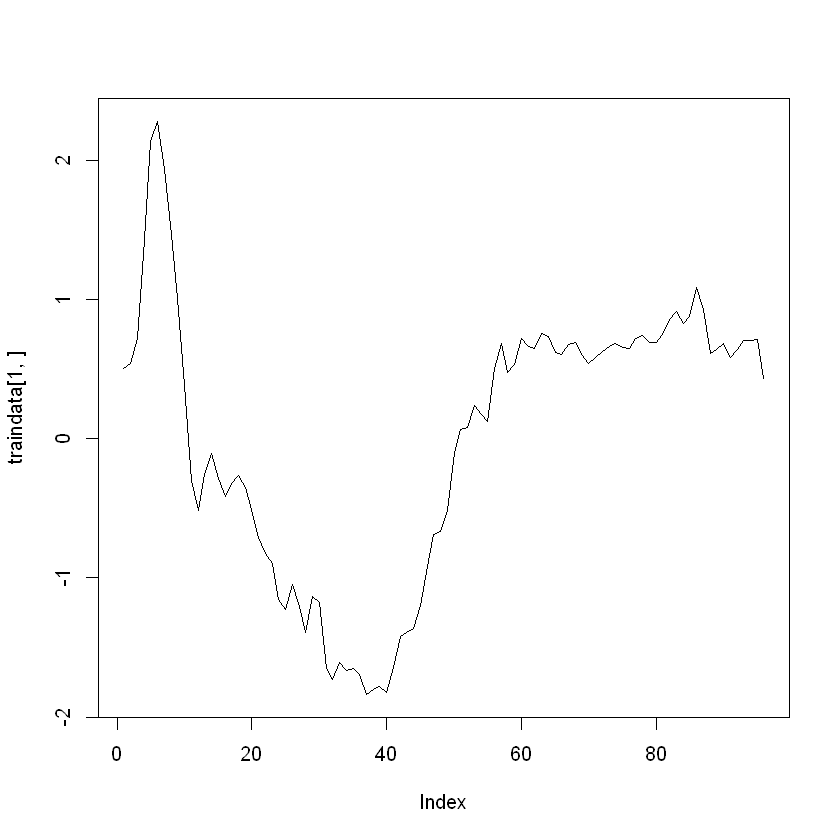

In [314]:
#let's use line format
plot(traindata[1,],type='l')

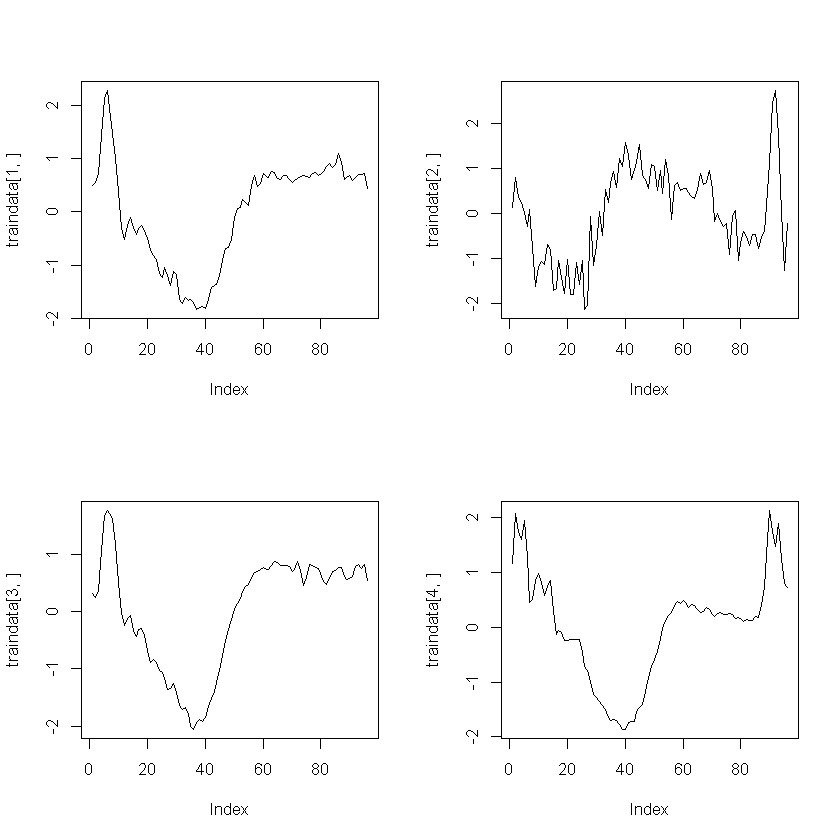

In [315]:
#multiple plots on single plot
par(mfrow=c(2,2)) #2x2 grid
plot(traindata[1,],type='l')
plot(traindata[2,],type='l')
plot(traindata[3,],type='l')
plot(traindata[4,],type='l')

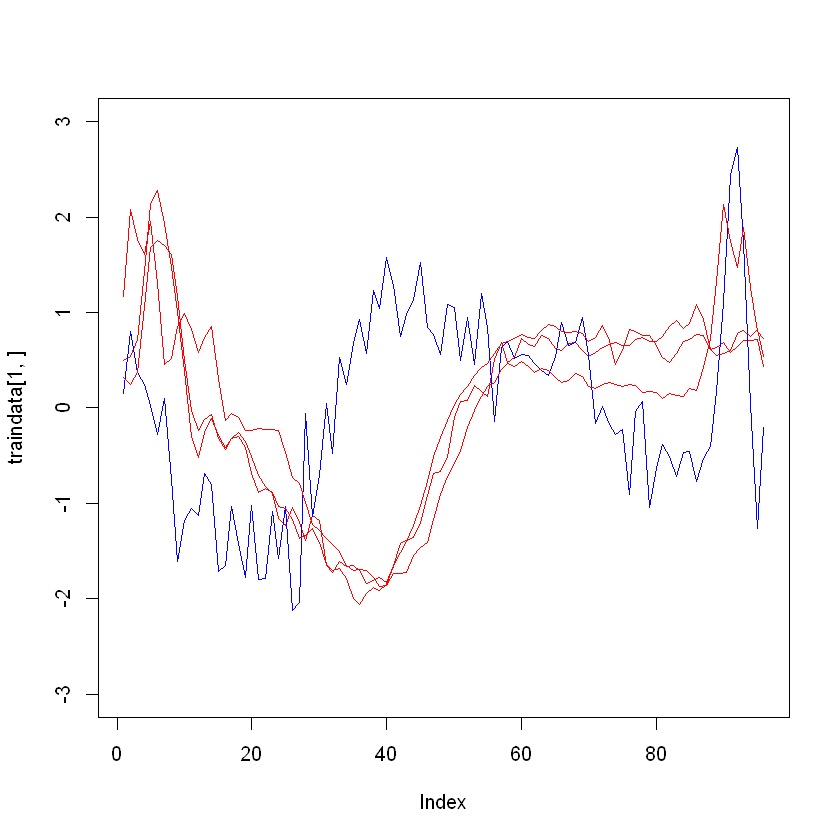

In [316]:
#problem with limits?
lim=max(abs(traindata[1:4,])) #maximum of the absolute value of the observations for first 4 time series
plot(traindata[1,],type='l',col=trainclass[1]+3,ylim=c(-1.1*lim,1.1*lim))
points(traindata[2,],type='l',col=trainclass[2]+3)
points(traindata[3,],type='l',col=trainclass[3]+3)
points(traindata[4,],type='l',col=trainclass[4]+3)

## Task a: Logistic Regression

In [5]:
require(penalized, quietly = TRUE)

Warning message:
"package 'penalized' was built under R version 3.6.3"Welcome to penalized. For extended examples, see vignette("penalized").


### Tuning L1 parameter

In [331]:
fit2a <- optL1(response = as.factor(trclass), penalized=traindata ,fusedl = TRUE, fold = 10, model = "logistic")

lambda= 8.374801 	cvl= -46.70331 
lambda= 13.55071 	cvl= -55.44112 
lambda= 5.175911 	cvl= -39.97299 
lambda= 3.198889 	cvl= -36.3063 
lambda= 1.977022 	cvl= -36.3903 
lambda= 2.645125 	cvl= -35.89841 
lambda= 2.616473 	cvl= -35.90233 
lambda= 2.676443 	cvl= -35.89494 
lambda= 2.875999 	cvl= -35.91903 
lambda= 2.787286 	cvl= -35.89266 
lambda= 2.748065 	cvl= -35.88762 
lambda= 2.736801 	cvl= -35.88916 
lambda= 2.755413 	cvl= -35.88672 
lambda= 2.767587 	cvl= -35.88632 
lambda= 2.765108 	cvl= -35.88565 
lambda= 2.76203 	cvl= -35.88598 
lambda= 2.764352 	cvl= -35.88573 
lambda= 2.766055 	cvl= -35.88585 
lambda= 2.765204 	cvl= -35.88564 
lambda= 2.765529 	cvl= -35.88569 


In [348]:
fit2a$lambda; fit2a$cvl

[1] 2.765204

[1] -35.88564

### Tuning L2 parameter

In [334]:
fit2a1 <- optL2(response = as.factor(trclass), penalized=traindata ,fusedl = TRUE, fold = 10,
               model = "logistic", lambda1 = fit2a$lambda )

lambda= Inf 	cvl= -63.62315 
lambda= 1 	cvl= -36.95078 
lambda= 10 	cvl= -43.42675 
lambda= 0.1 	cvl= -36.70208 
lambda= 0.01 	cvl= -37.33339 
lambda= 0.3881464 	cvl= -37.64095 
lambda= 0.6218536 	cvl= -38.1167 
lambda= 0.2437073 	cvl= -36.7799 
lambda= 0.1544391 	cvl= -36.63092 
lambda= 0.1536404 	cvl= -36.62696 
lambda= 0.09877463 	cvl= -36.82554 
lambda= 0.1326835 	cvl= -36.66819 
lambda= 0.1462545 	cvl= -36.63122 
lambda= 0.1503742 	cvl= -36.62309 
lambda= 0.1513672 	cvl= -36.62426 
lambda= 0.1488006 	cvl= -36.62329 
lambda= 0.1497139 	cvl= -36.62231 
lambda= 0.1496325 	cvl= -36.62221 
lambda= 0.1493148 	cvl= -36.62184 
lambda= 0.1491184 	cvl= -36.62231 
lambda= 0.1493886 	cvl= -36.62193 
lambda= 0.1492398 	cvl= -36.62193 
lambda= 0.1493152 	cvl= -36.62184 
lambda= 0.1492861 	cvl= -36.62181 
lambda= 0.1492684 	cvl= -36.62184 


In [349]:
fit2a1$lambda; fit2a1$cvl

[1] 0.1492861

[1] -36.62181

### Cross Check

In [337]:
fit2a2 <- optL1(response = as.factor(trclass), penalized=traindata ,fusedl = TRUE, fold = 10,
                model = "logistic", lambda2 = fit2a1$lambda)

lambda= 8.273808 	cvl= -46.55654 
lambda= 13.3873 	cvl= -55.41976 
lambda= 5.113494 	cvl= -39.718 
lambda= 3.160313 	cvl= -36.68453 
lambda= 1.953181 	cvl= -35.95552 
lambda= 1.55135 	cvl= -35.99962 
lambda= 1.875977 	cvl= -36.01572 
lambda= 2.414265 	cvl= -35.81494 
lambda= 2.69923 	cvl= -36.06982 
lambda= 2.238146 	cvl= -35.81539 
lambda= 2.327415 	cvl= -35.81164 
lambda= 2.329033 	cvl= -35.81171 
lambda= 2.293317 	cvl= -35.81089 
lambda= 2.291445 	cvl= -35.81089 
lambda= 2.291642 	cvl= -35.81089 
lambda= 2.264894 	cvl= -35.81132 
lambda= 2.281304 	cvl= -35.81096 
lambda= 2.286473 	cvl= -35.81091 
lambda= 2.289058 	cvl= -35.8109 
lambda= 2.29035 	cvl= -35.81089 
lambda= 2.290996 	cvl= -35.81089 


In [351]:
fit2a2$lambda; fit2a2$cvl

[1] 2.291445

[1] -35.81089

Cvl is increased!

### Re-tuning L2 

In [342]:
fit2a3 <- optL2(response = as.factor(trclass), penalized=traindata ,fusedl = TRUE, fold = 10,
                model = "logistic", lambda1 = fit2a2$lambda)

lambda= Inf 	cvl= -63.41946 
lambda= 1 	cvl= -36.09964 
lambda= 10 	cvl= -42.38113 
lambda= 0.1 	cvl= -34.86183 
lambda= 0.01 	cvl= -35.96723 
lambda= 0.3881464 	cvl= -35.50943 
lambda= 0.6218536 	cvl= -35.91821 
lambda= 0.2437073 	cvl= -34.83896 
lambda= 0.1544391 	cvl= -34.6626 
lambda= 0.1124857 	cvl= -34.79015 
lambda= 0.1732303 	cvl= -34.64507 
lambda= 0.1772798 	cvl= -34.63887 
lambda= 0.2026529 	cvl= -34.64891 
lambda= 0.1869444 	cvl= -34.64268 
lambda= 0.1807098 	cvl= -34.64056 
lambda= 0.175733 	cvl= -34.64036 
lambda= 0.178152 	cvl= -34.63927 
lambda= 0.1773263 	cvl= -34.63888 
lambda= 0.176689 	cvl= -34.6387 
lambda= 0.1763239 	cvl= -34.63926 
lambda= 0.1769147 	cvl= -34.63877 
lambda= 0.1765495 	cvl= -34.63887 
lambda= 0.1767656 	cvl= -34.63872 
lambda= 0.1766357 	cvl= -34.63872 
lambda= 0.1766981 	cvl= -34.6387 
lambda= 0.1766669 	cvl= -34.63869 


In [352]:
fit2a3$lambda; fit2a3$cvl

[1] 0.1766669

[1] -34.63869

Cvl is increased

### Re-tuning L1 

In [345]:
fit2a4 <- optL1(response = as.factor(trclass), penalized=traindata ,fusedl = TRUE, fold = 10,
                model = "logistic", lambda2 = fit2a3$lambda)

lambda= 8.343195 	cvl= -47.04823 
lambda= 13.49957 	cvl= -55.48221 
lambda= 5.156378 	cvl= -40.65456 
lambda= 3.186817 	cvl= -38.02194 
lambda= 1.969561 	cvl= -37.55926 
lambda= 1.945013 	cvl= -37.54634 
lambda= 1.202084 	cvl= -37.15555 
lambda= 0.742929 	cvl= -38.00784 
lambda= 1.485858 	cvl= -37.29289 
lambda= 1.026703 	cvl= -37.32141 
lambda= 1.266253 	cvl= -37.17358 
lambda= 1.135095 	cvl= -37.14707 
lambda= 1.114778 	cvl= -37.16812 
lambda= 1.163837 	cvl= -37.1346 
lambda= 1.164271 	cvl= -37.13551 
lambda= 1.151965 	cvl= -37.13423 
lambda= 1.145521 	cvl= -37.1383 
lambda= 1.157807 	cvl= -37.13469 
lambda= 1.149503 	cvl= -37.13515 
lambda= 1.154196 	cvl= -37.13434 
lambda= 1.151024 	cvl= -37.13455 
lambda= 1.152873 	cvl= -37.13424 
lambda= 1.152182 	cvl= -37.13419 
lambda= 1.152393 	cvl= -37.1342 


In [353]:
fit2a4$lambda; fit2a4$cvl

[1] 1.152182

[1] -37.13419

Cvl is decreased!. Best pair is **L1 = 2.2914** and **L2 = 0.1767**.

In [354]:
l1 = fit2a2$lambda; l2 = fit2a3$lambda; cat(l1,l2)

2.291445 0.1766669

### Training Model 

In [19]:
model2a <-penalized(response = as.factor(trclass), penalized = traindata, fusedl = TRUE,
                 model = "logistic", lambda1 = l1, lambda2 = l2 )

In [20]:
model2a

Penalized logistic regression object
97 regression coefficients of which 15 are non-zero

Loglikelihood =	 -27.10339 
L1 penalty =	 10.47812 	at lambda1 =  2.291445 
L2 penalty =	 0.7876814 	at lambda2 =  0.1766669 

### Testing Model 

In [21]:
preds2a <- predict(model2a, penalized = testdata  )

In [22]:
preds2aClass <- 1*(preds2a >= 0.5)

In [23]:
cat("CONFUSION MATRIX")
table( cbind(Actuals = as.data.frame(tsclass) ,Predictions = as.data.frame(preds2aClass)  ) )
acc = sum(preds2aClass == tsclass)/length(tsclass)
cat("Accuracy is: ",acc*100,"%" )

CONFUSION MATRIX

       preds2aClass
tsclass  0  1
      0 24 12
      1  6 58

Accuracy is:  82 %

## Task b: Interpretting Coefficients 

In [440]:
Coefficients = c(model2a@unpenalized,model2a@penalized)

In [442]:
Coefficients

(Intercept)                                                             
 0.23219917 -0.04725627  0.00000000  0.00000000  0.00000000  0.00000000 
                                                                        
-0.08419608 -0.39114726  0.00000000  0.00000000  0.00000000  0.00000000 
                                                                        
 0.79064001  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
                                                                        
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
                                                                        
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
                                                                        
-0.22413648 -0.22413648 -0.22413648 -0.10488391 -0.10488391 -0.10488391 
                                                                        
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
                                                                        
 0.00000000  0.00000000  0.46325784  0.46325784  0.00000000  0.00000000 
                                                                        
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
                                                                        
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
                                                                        
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
                                                                        
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
                                                                        
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
                                                                        
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
                                                                        
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
                                                                        
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 -0.67294817 
            
-0.67294817

In [445]:
dim(testdata)

[1] 100  96

Only **15** coefficients of the model is not equal to zero out of **96**. When we look at the coefficients, an interesting fact draws attention. We can see that many consecutive coefficients are equal. This outcome can be attributed to the fused loss function as equal consecutive coefficients would contribute zero to the fused loss function. Consecutive non-zero coefficients are as below:

$\theta_0 \neq \theta_1$   
$\theta_6 \neq \theta_7$   
$\theta_{30} = \theta_{31} = \theta_{32}$   
$\theta_{33} = \theta_{34} = \theta_{35}$    
$\theta_{44} = \theta_{45}$   
$\theta_{95} = \theta_{96}$   

Among coefficients, the one with highest values is $\theta_{12}$ and the ones with lowest value are $\theta_{95} = \theta_{96}$

## Task c: Using Differences 

### Creating Datasets 

In [6]:
diffstrain = traindata[,-1] - traindata[,- dim(traindata)[2] ]
diffstest = testdata[,-1] - testdata[,- dim(testdata)[2] ]

### Tuning L1

In [7]:
set.seed(7)
fit2b1 <- optL1(response = as.factor(trclass), penalized=diffstrain ,fusedl = TRUE, fold = 10, model = "logistic")

lambda= 5.59949 	cvl= -51.99793 
lambda= 9.060165 	cvl= -56.39873 
lambda= 3.460675 	cvl= -49.14314 
lambda= 2.138815 	cvl= -43.9736 
lambda= 1.32186 	cvl= -40.42611 
lambda= 0.8169546 	cvl= -40.92711 
lambda= 1.192344 	cvl= -39.96897 
lambda= 1.110594 	cvl= -39.8498 
lambda= 1.077145 	cvl= -39.86034 
lambda= 1.104112 	cvl= -39.84348 
lambda= 1.097165 	cvl= -39.84234 
lambda= 1.09929 	cvl= -39.8419 
lambda= 1.099579 	cvl= -39.84185 
lambda= 1.10131 	cvl= -39.84156 
lambda= 1.102381 	cvl= -39.8419 
lambda= 1.100927 	cvl= -39.84162 
lambda= 1.101719 	cvl= -39.8415 
lambda= 1.101972 	cvl= -39.84154 
lambda= 1.101682 	cvl= -39.8415 


In [8]:
fit2b1$lambda; fit2b1$cvl

[1] 1.101719

[1] -39.8415

### Tuning L2

In [9]:
set.seed(7)
fit2b2 <- optL2(response = as.factor(trclass), penalized=diffstrain ,fusedl = TRUE, fold = 10,
                model = "logistic", lambda1 = fit2b1$lambda)

lambda= Inf 	cvl= -63.15148 
lambda= 1 	cvl= -40.87305 
lambda= 10 	cvl= -55.08197 
lambda= 0.1 	cvl= -39.48898 
lambda= 0.01 	cvl= -39.84736 
lambda= 0.3881464 	cvl= -40.1331 
lambda= 0.6218536 	cvl= -40.42495 
lambda= 0.2437073 	cvl= -39.35899 
lambda= 0.1544391 	cvl= -39.40302 
lambda= 0.2089226 	cvl= -39.36683 
lambda= 0.2492229 	cvl= -39.38044 
lambda= 0.2274182 	cvl= -39.36134 
lambda= 0.2374854 	cvl= -39.36182 
lambda= 0.2413308 	cvl= -39.36468 
lambda= 0.2458141 	cvl= -39.37307 
lambda= 0.2427995 	cvl= -39.36685 
lambda= 0.244512 	cvl= -39.37035 
lambda= 0.2433606 	cvl= -39.36798 
lambda= 0.2440147 	cvl= -39.36932 
lambda= 0.2435749 	cvl= -39.36842 
lambda= 0.2438247 	cvl= -39.36893 
lambda= 0.2436567 	cvl= -39.36859 
lambda= 0.2437521 	cvl= -39.36878 


In [10]:
fit2b2$lambda; fit2b2$cvl

[1] 0.2437073

[1] -39.35899

(Note: I could note tune further because of crashes) 

In [11]:
l1 = fit2b1$lambda; l2 = fit2b2$lambda; cat(l1,l2)

1.101719 0.2437073

### Training Model

In [12]:
set.seed(7)
model2b <-penalized(response = as.factor(trclass), penalized = diffstrain, fusedl = TRUE,
                 model = "logistic", lambda1 = l1, lambda2 = l2 )

In [13]:
model2b

Penalized logistic regression object
96 regression coefficients of which 21 are non-zero

Loglikelihood =	 -29.43123 
L1 penalty =	 11.05014 	at lambda1 =  1.101719 
L2 penalty =	 2.022953 	at lambda2 =  0.2437073 

### Testing Model 

In [14]:
preds2b <- predict(model2b, penalized = diffstest  )

In [15]:
preds2bClass <- 1*(preds2b >= 0.5)

In [27]:
cat("MODEL A CONFUSION MATRIX")
table( cbind(Actuals = as.data.frame(tsclass) ,Predictions = as.data.frame(preds2aClass)  ) )
acc = sum(preds2aClass == tsclass)/length(tsclass)
cat("Accuracy is: ",acc*100,"%\n\n" )

cat("MODEL B CONFUSION MATRIX")
table( cbind(Actuals = as.data.frame(tsclass) ,Predictions = as.data.frame(preds2bClass)  ) )
acc = sum(preds2bClass == tsclass)/length(tsclass)
cat("Accuracy is: ",acc*100,"%" )

MODEL A CONFUSION MATRIX

       preds2aClass
tsclass  0  1
      0 24 12
      1  6 58

Accuracy is:  82 %

MODEL B CONFUSION MATRIX

       preds2bClass
tsclass  0  1
      0 27  9
      1  7 57

Accuracy is:  84 %

Looking at confusion matricies, in the second model, **3 more observations** from **class -1**, and **1 less observation** from **class 1** were predicted correctly. Overall, second model is better looking at accuracy scores which are **82%** and **84%** in order.         
To sum up, **Model B** has better **Accuracy** and **Specifity** rate and **Model A** has better **Sensitivity** rate. 

## Task d: Interpretting Coefficients 

In [30]:
CoefficientsB = c(model2b@unpenalized,model2b@penalized)

In [31]:
CoefficientsB

(Intercept)                                                             
-0.58923664  0.30399467  0.89388595  0.00000000 -0.45334709 -0.05210833 
                                                                        
 0.00000000  0.27823939  0.28714160  0.28714160  0.28168414  0.28168414 
                                                                        
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
                                                                        
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
                                                                        
 0.00000000  0.00000000  0.00000000  0.00000000 -0.23693128 -0.23693128 
                                                                        
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.55606199 
                                                                        
 0.60212123  0.99791836  0.99791836  0.99791836  0.24431557  0.00000000 
                                                                        
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
                                                                        
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
                                                                        
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
                                                                        
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
                                                                        
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
                                                                        
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 -0.82573374 
                                                                        
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
                                                                        
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
                                                                        
 0.00000000  0.00000000  0.00000000 -0.60741369 -0.60741369  0.00000000

In [38]:
length(coef(model2b))

[1] 21

In [39]:
dim(diffstest)

[1] 100  95

**21** coefficients of the model is not equal to zero out of **95**. This model has more non-zero coefficients compared to **Model A**. Again, many consecutive coefficients are equal in this model too as expected but there are more exceptions in this one. Non-zero coefficients can be seen below:

$\theta_0 \neq \theta_1 \neq \theta_2 \neq \theta_4 \neq \theta_5$   
$\theta_7 \neq \theta_8 = \theta_9 \neq \theta_{10} = \theta_{11} $ (All have very close values.)    
$\theta_{28} = \theta_{29}$   
$\theta_{35} \neq \theta_{36} \neq \theta_{37} = \theta_{38} = \theta_{39} \neq \theta_{40}$    
$\theta_{77}$   
$\theta_{93} = \theta_{94}$   

Among coefficients, $\theta_{37} = \theta_{38} = \theta_{39}$ share the highest value and the one with the lowest value is $\theta_{77}$.

Comparing to the coefficients of the **Model A**, **7 variables** that had non-zero coefficients in Model A have its related coefficients both **zero** in this model. Which are: $x_{31}, x_{32}, x_{33}, x_{34}, x_{44}, x_{45}$ and $x_{96} $. Rest of the variables have at least one related coefficient non-zero in Model B.

## Task e: Combined Set 

### Creating Datasets 

In [49]:
colnames(diffstrain) <- paste("diff",colnames(diffstrain),sep="")
colnames(diffstest) <- paste("diff",colnames(diffstest),sep="")

In [50]:
combinedtrain = cbind(traindata, diffs = diffstrain)
combinedtest = cbind(testdata, diffs = diffstest)

### Tuning L1

In [52]:
set.seed(7)
fit2c1 <- optL1(response = as.factor(trclass), penalized=combinedtrain ,fusedl = TRUE, fold = 10, model = "logistic")

lambda= 8.362104 	cvl= -47.37956 
lambda= 13.53017 	cvl= -55.1972 
lambda= 5.168065 	cvl= -41.3855 
lambda= 3.19404 	cvl= -38.45015 
lambda= 1.974025 	cvl= -37.0869 
lambda= 1.220015 	cvl= -38.44436 
lambda= 2.206035 	cvl= -37.22086 
lambda= 1.970313 	cvl= -37.08589 
lambda= 1.865786 	cvl= -37.07762 
lambda= 1.619123 	cvl= -37.38286 
lambda= 1.896086 	cvl= -37.07161 
lambda= 1.907468 	cvl= -37.07384 
lambda= 1.891422 	cvl= -37.07084 
lambda= 1.881629 	cvl= -37.07236 
lambda= 1.890024 	cvl= -37.07062 
lambda= 1.886818 	cvl= -37.07089 
lambda= 1.889218 	cvl= -37.0705 
lambda= 1.888301 	cvl= -37.07049 
lambda= 1.88864 	cvl= -37.07042 
lambda= 1.88876 	cvl= -37.07044 


In [53]:
fit2c1$lambda; fit2c1$cvl

[1] 1.88864

[1] -37.07042

### Tuning L2

In [54]:
set.seed(7)
fit2c2 <- optL2(response = as.factor(trclass), penalized=combinedtrain ,fusedl = TRUE, fold = 10,
                model = "logistic", lambda1 = 1.88864037732801)

lambda= Inf 	cvl= -63.15148 
lambda= 1 	cvl= -35.75647 
lambda= 10 	cvl= -42.49461 
lambda= 0.1 	cvl= -35.83539 
lambda= 3.881464 	cvl= -39.49009 
lambda= 6.218536 	cvl= -40.82693 
lambda= 2.437073 	cvl= -38.56437 
lambda= 1.544391 	cvl= -36.69081 
lambda= 0.9926824 	cvl= -35.74371 
lambda= 0.6517081 	cvl= -35.41035 
lambda= 0.2316834 	cvl= -35.50094 
lambda= 0.5104659 	cvl= -35.42077 
lambda= 0.6535639 	cvl= -35.41058 
lambda= 0.6081957 	cvl= -35.42521 
lambda= 0.6350878 	cvl= -35.42098 
lambda= 0.6453597 	cvl= -35.41481 
lambda= 0.6520333 	cvl= -35.41075 
lambda= 0.6492832 	cvl= -35.41115 
lambda= 0.6507819 	cvl= -35.41067 
lambda= 0.6513543 	cvl= -35.41071 
lambda= 0.651573 	cvl= -35.41072 
lambda= 0.6518323 	cvl= -35.41074 


In [56]:
fit2c2$lambda; fit2c2$cvl

[1] 0.6517081

[1] -35.41035

### Cross Check 

In [57]:
set.seed(7)
fit2c3 <- optL1(response = as.factor(trclass), penalized=combinedtrain ,fusedl = TRUE, fold = 10,
                model = "logistic", lambda2 = 0.651708091008328)

lambda= 8.362104 	cvl= -47.99788 
lambda= 13.53017 	cvl= -56.27814 
lambda= 5.168065 	cvl= -41.79184 
lambda= 3.19404 	cvl= -38.13353 
lambda= 1.974025 	cvl= -35.72225 
lambda= 1.220015 	cvl= -35.07178 
lambda= 0.8325308 	cvl= -36.43173 
lambda= 1.484411 	cvl= -34.95247 
lambda= 1.436289 	cvl= -34.92158 
lambda= 1.39685 	cvl= -34.90618 
lambda= 1.329305 	cvl= -34.98911 
lambda= 1.348584 	cvl= -34.95159 
lambda= 1.403707 	cvl= -34.9069 
lambda= 1.394349 	cvl= -34.90423 
lambda= 1.376869 	cvl= -34.90188 
lambda= 1.383525 	cvl= -34.90157 
lambda= 1.3816 	cvl= -34.90113 
lambda= 1.380604 	cvl= -34.90111 
lambda= 1.380932 	cvl= -34.90104 
lambda= 1.381069 	cvl= -34.90102 
lambda= 1.381272 	cvl= -34.90105 


In [58]:
fit2c3$lambda; fit2c3$cvl

[1] 1.381069

[1] -34.90102

### Re-tuning L2 

In [66]:
set.seed(7)
fit2c4 <- optL2(response = as.factor(trclass), penalized=combinedtrain ,fusedl = TRUE, fold = 10,
                model = "logistic", lambda1 = fit2c3$lambda)

lambda= Inf 	cvl= -63.15148 
lambda= 1 	cvl= -35.32308 
lambda= 10 	cvl= -42.36754 
lambda= 0.1 	cvl= -36.55996 
lambda= 3.881464 	cvl= -38.79285 
lambda= 6.218536 	cvl= -41.89447 
lambda= 2.437073 	cvl= -37.99506 
lambda= 1.811408 	cvl= -36.84908 
lambda= 1.157708 	cvl= -35.5465 
lambda= 0.7536997 	cvl= -34.91139 
lambda= 0.5040086 	cvl= -35.14379 
lambda= 0.7504047 	cvl= -34.90875 
lambda= 0.6951001 	cvl= -34.8884 
lambda= 0.6221097 	cvl= -34.90989 
lambda= 0.6871192 	cvl= -34.8962 
lambda= 0.7140965 	cvl= -34.88058 
lambda= 0.7144154 	cvl= -34.88081 
lambda= 0.7081003 	cvl= -34.8764 
lambda= 0.7031347 	cvl= -34.87737 
lambda= 0.7068165 	cvl= -34.87574 
lambda= 0.7061233 	cvl= -34.87578 
lambda= 0.7065536 	cvl= -34.87561 
lambda= 0.7064883 	cvl= -34.87558 
lambda= 0.7063489 	cvl= -34.87566 


In [67]:
fit2c4$lambda; fit2c4$cvl

[1] 0.7064883

[1] -34.87558

Cvl does not improve a lot. We can use this fit.

In [68]:
l1 = fit2c3$lambda; l2 = fit2c4$lambda; cat(l1,l2)

1.381069 0.7064883

### Training Model 

In [69]:
set.seed(7)
model2c <-penalized(response = as.factor(trclass), penalized = combinedtrain, fusedl = TRUE,
                 model = "logistic", lambda1 = l1, lambda2 = l2 )

In [70]:
model2c

Penalized logistic regression object
192 regression coefficients of which 26 are non-zero

Loglikelihood =	 -25.92308 
L1 penalty =	 7.67544 	at lambda1 =  1.381069 
L2 penalty =	 2.596797 	at lambda2 =  0.7064883 

### Testing Model

In [71]:
preds2c <- predict(model2c, penalized = combinedtest  )

In [72]:
preds2cClass <- 1*(preds2c >= 0.5)

In [73]:
cat("MODEL A CONFUSION MATRIX")
table( cbind(Actuals = as.data.frame(tsclass) ,Predictions = as.data.frame(preds2aClass)  ) )
acc = sum(preds2aClass == tsclass)/length(tsclass)
cat("Accuracy is: ",acc*100,"%\n\n" )

cat("MODEL B CONFUSION MATRIX")
table( cbind(Actuals = as.data.frame(tsclass) ,Predictions = as.data.frame(preds2bClass)  ) )
acc = sum(preds2bClass == tsclass)/length(tsclass)
cat("Accuracy is: ",acc*100,"%\n\n" )

cat("MODEL C CONFUSION MATRIX")
table( cbind(Actuals = as.data.frame(tsclass) ,Predictions = as.data.frame(preds2cClass)  ) )
acc = sum(preds2cClass == tsclass)/length(tsclass)
cat("Accuracy is: ",acc*100,"%" )

MODEL A CONFUSION MATRIX

       preds2aClass
tsclass  0  1
      0 24 12
      1  6 58

Accuracy is:  82 %

MODEL B CONFUSION MATRIX

       preds2bClass
tsclass  0  1
      0 27  9
      1  7 57

Accuracy is:  84 %

MODEL C CONFUSION MATRIX

       preds2cClass
tsclass  0  1
      0 25 11
      1  6 58

Accuracy is:  83 %

Results of the **Model C** resulted between **A** and **B**. The Accuracy value is **83%**.

## Task f: Interpreting Coefficients 

In [74]:
CoefficientsC = c(model2c@unpenalized,model2c@penalized)

In [76]:
CoefficientsC

(Intercept)          V2          V3          V4          V5          V6 
 0.37092106 -0.17483665  0.00000000  0.00000000  0.00000000  0.00000000 
         V7          V8          V9         V10         V11         V12 
-0.20445573 -0.20445573 -0.20445573  0.00000000  0.00000000  0.03319960 
        V13         V14         V15         V16         V17         V18 
 0.35911018  0.35911018  0.00000000  0.00000000  0.00000000  0.00000000 
        V19         V20         V21         V22         V23         V24 
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
        V25         V26         V27         V28         V29         V30 
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
        V31         V32         V33         V34         V35         V36 
-0.21423624 -0.21423624 -0.21423624 -0.21423624 -0.21423624 -0.21423624 
        V37         V38         V39         V40         V41         V42 
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.15269462 
        V43         V44         V45         V46         V47         V48 
 0.15269462  0.15269462  0.15269462  0.15269462  0.15269462  0.00000000 
        V49         V50         V51         V52         V53         V54 
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
        V55         V56         V57         V58         V59         V60 
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
        V61         V62         V63         V64         V65         V66 
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
        V67         V68         V69         V70         V71         V72 
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
        V73         V74         V75         V76         V77         V78 
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
        V79         V80         V81         V82         V83         V84 
 0.00000000  0.00000000  0.00000000 -0.08829425 -0.08829425 -0.08829425 
        V85         V86         V87         V88         V89         V90 
-0.08829425  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
        V91         V92         V93         V94         V95         V96 
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 -0.73161120 
        V97      diffV3      diffV4      diffV5      diffV6      diffV7 
-0.73161120  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
     diffV8      diffV9     diffV10     diffV11     diffV12     diffV13 
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
    diffV14     diffV15     diffV16     diffV17     diffV18     diffV19 
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
    diffV20     diffV21     diffV22     diffV23     diffV24     diffV25 
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
    diffV26     diffV27     diffV28     diffV29     diffV30     diffV31 
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
    diffV32     diffV33     diffV34     diffV35     diffV36     diffV37 
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
    diffV38     diffV39     diffV40     diffV41     diffV42     diffV43 
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
    diffV44     diffV45     diffV46     diffV47     diffV48     diffV49 
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
    diffV50     diffV51     diffV52     diffV53     diffV54     diffV55 
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
    diffV56     diffV57     diffV58     diffV59     diffV60     diffV61 
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
    diffV62     diffV63     diffV64     diffV65     diffV66     diffV67 
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000 
    diffV68     diffV69     diffV70     diffV71     diffV7

In [77]:
length(coef(model2c))

[1] 26

In [78]:
dim(combinedtest)

[1] 100 191

**26** coefficients of the model is not equal to zero out of **191**. Number of non-zero coefficients is increased but ratio of the number of non-zero coefficients is the lowest in this model. Looking at the cooefficients, only those belong to the **Model A** are non-zero. Somewhat we have a model very similar to the model A but with better results.  

All coefficients that are non-zero in the Model A are non-zero in this model as well. Additionally, $\theta_8$, $\theta_{11}$, $\theta_{13}$, $\theta_{41}$, $\theta_{42}$, $\theta_{43}$, $\theta_{46}$, $\theta_{81}$, $\theta_{82}$, $\theta_{83}$ and $\theta_{84}$. Also, these coefficients are equal:

$\theta_6 = \theta_7 = \theta_8$    
$\theta_{12} = \theta_{13}$    
$\theta_{30} = \theta_{31} = \theta_{32} = \theta_{33} = \theta_{34} = \theta_{35}$    
$\theta_{41} = \theta_{42} = \theta_{43} = \theta_{44} = \theta_{45} = \theta_{46}$    
$\theta_{81} = \theta_{82} = \theta_{83} = \theta_{84}$    
$\theta_{95} = \theta_{96}$ 

Looking the equations above, we have longer sequences of equal coefficients in this model different from previous models.